# Improving performance and low-level distributed computing

### Name: Ana Belen Barcenas J.

## Performance

This homework provides practice in making Python code faster. Note that we start with functions that already use idiomatic `numpy` (which are about two orders of magnitude faster than the pure Python versions).

In [1]:
%matplotlib inline
%load_ext Cython

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs 
from numba import jit, vectorize, float64, int64

In [3]:
sns.set_context('notebook', font_scale=1.5)

**Functions to optimize**

In [44]:
def logistic(x):
    """Logistic function."""
    return np.exp(x)/(1 + np.exp(x))

def gd(X, y, beta, alpha, niter):
    """Gradient descent algorihtm."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

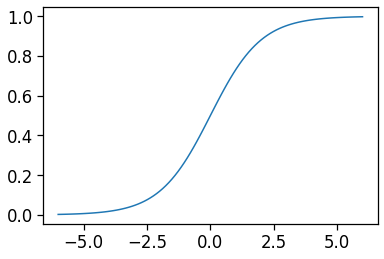

In [5]:
x = np.linspace(-6, 6, 100)
plt.plot(x, logistic(x))
pass

**Data set for classification**

In [35]:
n = 10000
p = 2
X, y = make_blobs(n_samples=n, n_features=p, centers=2, cluster_std=1.05, random_state=23)
X = np.c_[np.ones(len(X)), X]
y = y.astype('float')

**Using gradient descent for classification by logistic regression**

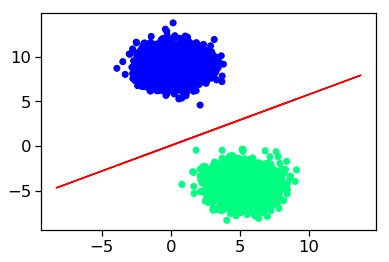

In [36]:
# initial parameters
niter = 1000
α = 0.01
β = np.zeros(p+1)

# call gradient descent
β = gd(X, y, β, α, niter)

# assign labels to points based on prediction
y_pred = logistic(X @ β)
labels = y_pred > 0.5

# calculate separating plane
sep = (-β[0] - β[1] * X)/β[2]

plt.scatter(X[:, 1], X[:, 2], c=labels, cmap='winter')
plt.plot(X, sep, 'r-')
pass

**1**. (10 points)

Rewrite the `logistic` function so it only makes one `np.exp` call. Compare the time of both versions with the input x given below using the `@timeit` magic. 

In [5]:
from timeit import timeit

In [6]:
np.random.seed(123)
n = int(1e7)
x = np.random.normal(0, 1, n)

In [7]:
def logistic_ab(x):
    """Logistic function optimized."""
    return 1/(1 + np.exp(-x))

In [45]:
%%time

logistic(x)

CPU times: user 207 ms, sys: 50.5 ms, total: 258 ms
Wall time: 282 ms


array([0.25244196, 0.73053634, 0.57027629, ..., 0.37094977, 0.52119368,
       0.71561529])

In [10]:
%%time

logistic_ab(x)

CPU times: user 112 ms, sys: 28.1 ms, total: 141 ms
Wall time: 140 ms


array([0.25244196, 0.73053634, 0.57027629, ..., 0.37094977, 0.52119368,
       0.71561529])

It is almost 2 times faster the logistic function that only makes one np.exp call.

**2**. (20 points) 

Use `numba` to compile the gradient descent function. 


**2.1** Use the `@vectorize` decorator to create a ufunc version of the logistic function and call this `logistic_numba_cpu` with function signatures of `float64(float64)`. Create another function called `logistic_numba_parallel` by giving an extra argument to the decorator of `target=parallel` (5 points)

In [11]:
from numba import jit, njit

In [14]:
from numba import vectorize, float64

@vectorize([float64(float64)])
def logistic_numba_cpu(x):
    """Logistic ufunc using @vectorize decorator."""
    return 1/(1 + np.exp(-x))

@vectorize([float64(float64)], target='parallel')
def logistic_numba_parallel(x):
    """Logistic ufunc using @vectorize decorator and target = parallel."""
    return 1/(1 + np.exp(-x))

**2.2** For each function, check that the answers are the same as with the original logistic function using  `np.testing`. Use `%timeit` to compare the three logistic functions (5 points)

In [29]:
%%time
l1 = logistic_ab(x)

CPU times: user 103 ms, sys: 14.2 ms, total: 117 ms
Wall time: 118 ms


In [30]:
%%time
l2 = logistic_numba_cpu(x)

CPU times: user 79.1 ms, sys: 7.23 ms, total: 86.4 ms
Wall time: 86.7 ms


In [31]:
%%time
l3 = logistic_numba_parallel(x)

CPU times: user 117 ms, sys: 6.44 ms, total: 124 ms
Wall time: 51.7 ms


In [28]:
assert(np.allclose(l1, l2))
assert(np.allclose(l2, l3))

The outputs of each logistic are indeed equal as expected. Numba CPU seems to be the most efficient/faster compilation.

**2.3** Now use `@jit` to create a JIT_compiled version of the `logistic` and `gd` functions, calling them `logistic_numba` and `gd_numba`. Provide appropriate function signatures to the decorator in each case. (5 points)

In [32]:
@jit(float64[:](float64[:]))

def logistic_numba(x):
    """Logistic function using numba."""
    return np.exp(x)/(1 + np.exp(x))

In [40]:
@jit(float64[:](float64[:,:], float64[:], float64[:], float64, int64))

def gd_numba(X, y, beta, alpha, niter):
    """Gradient descent algorihtm using numba."""
    n, p = X.shape
    Xt = X.T
    for i in range(niter):
        y_pred = logistic(X @ beta)
        epsilon = y - y_pred
        grad = Xt @ epsilon / n
        beta += alpha * grad
    return beta

**2.4** Compare the two gradient descent functions `gd` and `gd_numba` for correctness and performance. (5 points)

In [54]:
%%time
gd1 = gd(X, y, β, α, niter)

CPU times: user 184 ms, sys: 17.4 ms, total: 202 ms
Wall time: 185 ms


In [47]:
%%time
gd2 = gd_numba(X, y, β, α, niter)

CPU times: user 187 ms, sys: 14.2 ms, total: 201 ms
Wall time: 197 ms


In [43]:
assert(np.allclose(gd1, gd2))

Both gradient descent function outputs are equal. The running time seems to be pretty much the same in both cases.

**3**. (20 points) 

Use `cython` to compile the gradient descent function. 


Hints: 

- Give static types to all variables
- Know how to use `def`, `cdef` and `cpdef`
- Use Typed MemoryViews
- Find out how to transpose a Typed MemoryView to store the transpose of X
- Typed MemoryVeiws are not `numpy` arrays - you often have to write explicit loops to operate on them
- Use the cython boundscheck, wraparound, and cdivision operators

**3.1** Cythonize the logistic function as `logistic_cython`. Use the `--annotate (-a)` argument to the `cython` magic function to find slow regions. Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (10 points)

**3.2** Now cythonize the gd function as `gd_cython`. This function should use of the cythonized `logistic_cython` as a C function call.  Compare accuracy and performance. The final performance should be comparable to the `numba` cpu version. (20 points)

In [49]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [72]:
%%cython --a
import cython
import numpy as np
cimport numpy as np
from libc.math cimport exp


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def logistic_cython(double[:] x):
    """
    Logistic function using cython
    
    x has shape (n,1)
    """
    
    cdef int i,n
    n = x.shape[0]
    
    cdef double[:] y = np.empty(n) 
    
    for i in range(n): y[i] = 1/(1 + exp(x[i])**(-1))
    return y




@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)

def gd_cython(double[:, :] X, double[:] y, double[:] beta, double alpha, int niter):
    """Gradient descent algorihtm using cython
    
    X has shape (n,p)
    y has shape (n,1)
    beta has shape (1,p+1)
    alpha has shape (1,1)
    niter is an integer
    
    """    
    
    cdef int n = X.shape[0]
    cdef int p = X.shape[1] 
    cdef double[:] epsilon, y_pred, grad
    cdef double[:, :] Xt 
    cdef int i
    
    epsilon = np.empty(n)
    y_pred = np.empty(n)
    grad = np.empty(p)  
    Xt = X.T

    for i in range(niter):
        y_pred = logistic_cython(np.dot(X, beta))
        epsilon[i] = y[i] - y_pred[i]
        grad = np.dot(Xt, epsilon) / n
        beta[i] += alpha * grad[i]
    return beta

Let's check for accuracy and performance comparing with numba_cpu

In [75]:
%%time
l1_ = logistic_cython(x)

CPU times: user 105 ms, sys: 23 ms, total: 128 ms
Wall time: 130 ms


In [79]:
%%time
l2_ = logistic_numba_cpu(x)

CPU times: user 85.5 ms, sys: 8.17 ms, total: 93.6 ms
Wall time: 97.1 ms


In [78]:
assert(np.allclose(l1_, l2_))

Numba_cpu seems to be sligthly faster than cython.

In [82]:
# initialize parameters for gradient descent
niter = 1000
alpha = 0.01
beta = np.zeros(p+1)

In [86]:
%%time
gd1_ = gd(X, y, beta, alpha, niter)

CPU times: user 192 ms, sys: 15.9 ms, total: 208 ms
Wall time: 197 ms


In [87]:
%%time
gd2_ = gd_cython(X, y, beta, alpha, niter)

CPU times: user 131 ms, sys: 14.1 ms, total: 145 ms
Wall time: 133 ms


In [89]:
assert(np.allclose(gd1_, gd2_))

In this case, cython runs faster than numba.

**4**. (50 points)

Write a program using `spark` to find 5 most common k-mers (shifting windows of length k) in the C. elegans genome. Ignore case when processing k-mers. You can work one line at a time - we will ignore k-mers that wrap around lines. You should write a function that takes a path to FASTA files and a value for k, and returns an key-value RDD of k-mer counts. Remember to strip comment lines that begin with '>' from the anlaysis. 

**Note**: 

- Use the low level RDD interface for this exercise.
- The textFile method takes an optional second argument for controlling the number of partitions of the file. By default, Spark creates one partition for each block of the file (blocks being 128MB by default in HDFS), but you can also ask for a higher number of partitions by passing a larger value. Please set this paramter to 60 - it will speed up processing.

**Check**: Use the C. elegans genome at `/data/c_elegans/*fa`. You should get 

```
[
(u'ATATATATATATATATATAT', 2168), 
(u'TATATATATATATATATATA', 2142), 
(u'CTCTCTCTCTCTCTCTCTCT', 1337), 
(u'TCTCTCTCTCTCTCTCTCTC', 1327), 
(u'AGAGAGAGAGAGAGAGAGAG', 1007)
]
```

**Instructions for local Spark installation**

If you are doing this on your own machine, you can download the DNA sequence from 

ftp://ftp.wormbase.org/pub/wormbase/releases/WS272/species/c_elegans/PRJNA13758/c_elegans.PRJNA13758.WS272.genomic.fa.gz

The results might be slightly different since this may be a newer consensus sequence than the one on HDFS in the Docker container.

You will probably need to also load SparkContext explicitly if doing this on your laptop.

```python
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.SparkContext()
```

In [1]:
import os

from pyspark.sql import SparkSession

spark = SparkSession \
     .builder \
     .appName("ABBJ_HW4") \
     .getOrCreate() 
sc=spark.sparkContext
path='c_elegans.PRJNA13758.WS272.genomic.fa'
file=sc.textFile(path, 60)

In [2]:
# Let's look at the top 5 lines in the file
file.top(5)

['TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTAATGGATCTTTAAAACTTTTTGCAAGTTT',
 'TTTTTTTTTTTTTTTTTTTTTTAAATTGTGAAAAACGTTGAAAAGTTCACTTTGGAAAAA',
 'TTTTTTTTTTTTTTTTTTTTTTAAACTTTAATATCTGCTTTATGTTCCATGTCCAACGAT',
 'TTTTTTTTTTTTTTTTTTTTTGGGTTTTTTTGTTTTTCAAAAACTTCAATTTTTTGTTTT',
 'TTTTTTTTTTTTTTTTTTTTGTTCCGATGCTTTTATTTTTAACAGTTTTTGCAAAAATAG']

In [3]:
# How many lines does the file has?
file.count()

1671451

In [19]:
def k_mers(path, k):
    '''
    Find 5 most common k-mers in the file extracted from "path".
    '''
    k_mers = (sc.textFile(path, 60).map(lambda line: line.upper())
              .filter(lambda line: line[0]!='>')
              .flatMap(lambda line: [line[symbol:symbol+k] for symbol in range(0, len(line) - k + 1)])
              .map(lambda k_mers: (k_mers, 1))
              .reduceByKey(lambda a, b: a + b)
              .takeOrdered(5, key=lambda x: -x[1])) 
              
    return k_mers

In [21]:
%%time
h = k_mers(path,3)

CPU times: user 52 ms, sys: 0 ns, total: 52 ms
Wall time: 29.4 s


In [30]:
print('Five most common 3 mers:')
for i in h:
    print(i[0])

Five most common 3 mers:
TTT
AAA
ATT
AAT
GAA
